In [1]:
from PIL import Image
import torch
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES

from inference_utils.inference import interactive_infer_image_all
from inference_utils.output_processing import check_mask_stats

/home/theodorezhao/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Deformable Transformer Encoder is not available.


/home/theodorezhao/miniconda3/envs/biomedparse/lib/python3.9/site-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/theodorezhao/miniconda3/envs/biomedparse/lib/python3.9/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/theodorezhao/miniconda3/envs/biomedparse/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
import huggingface_hub

HF_TOKEN = 'YOUR_HUGGINGFACE_TOKEN'

huggingface_hub.login(HF_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/theodorezhao/.cache/huggingface/token
Login successful


### Model Setup

In [3]:
# Build model config
opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
opt = init_distributed(opt)

# Load model from pretrained weights
pretrained_pth = 'hf_hub:microsoft/BiomedParse'

model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

/home/theodorezhao/miniconda3/envs/biomedparse/lib/python3.9/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


/home/theodorezhao/miniconda3/envs/biomedparse/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/theodorezhao/miniconda3/envs/biomedparse/lib/python3.9/site-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly 

### Utility Functions

In [4]:
from detectron2.data.datasets.builtin_meta import COCO_CATEGORIES

colors_list = [(np.array(color['color'])).tolist() for color in COCO_CATEGORIES]
color_codes = [f'#{color[0]:02x}{color[1]:02x}{color[2]:02x}' for color in colors_list]

def plot_segmentation_masks(original_image, segmentation_masks, texts):
    ''' Plot a list of segmentation masks on the same image.
    '''
    original_image = original_image[:, :, :3]
    mask_temp = original_image.copy()
    for i, mask in enumerate(segmentation_masks):
        mask_temp[mask > 0.5] = colors_list[i]
    
    # merge the original image with the masks
    image_to_show = (original_image * 0.5 + mask_temp * 0.5) / 255.0
    
        
    # plot the final image
    plt.imshow(image_to_show)
    plt.axis('off')
    
    # add the legend with marker size 20
    for i, text in enumerate(texts):
        plt.plot([], [], '.', color=color_codes[i], markersize=20, label=text)
    # legend to the right outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [5]:
!pip install pydicom nibabel SimpleITK

import json
import matplotlib.pyplot as plt

from inference_utils.processing_utils import read_rgb


def inference_recognition(file_path, image_type, p_value_threshold=None):
    image = read_rgb(file_path)
    
    predictions = interactive_infer_image_all(model, Image.fromarray(image), image_type, p_value_threshold)
    targets = list(predictions.keys())
    pred_mask = [predictions[t] for t in targets]
    # Plot feature over image
    plot_segmentation_masks(image, pred_mask, targets)
    
    return image, pred_mask


### Pathology Example

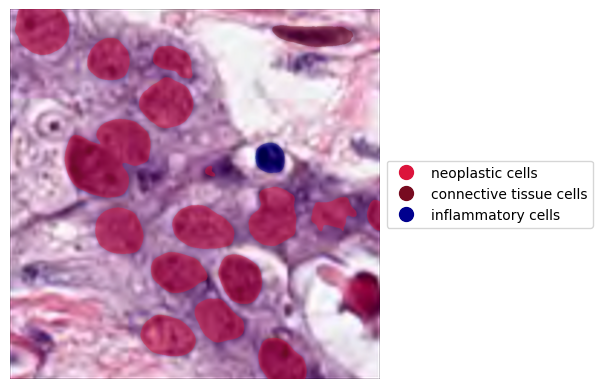

In [6]:
image_path = 'examples/Part_1_516_pathology_breast.png'
image_type = 'Pathology'

image, pred_mask = inference_recognition(image_path, image_type)

### X-Ray Example

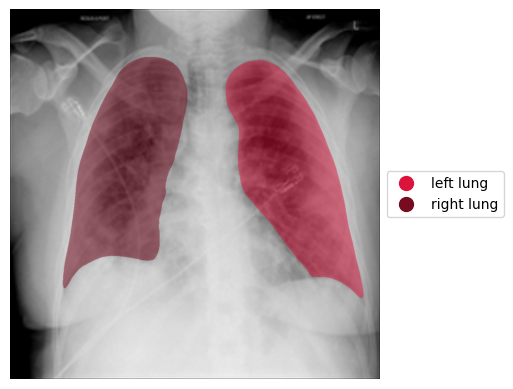

In [7]:
image_path = 'examples/covid_1585.png'
image_type = 'X-Ray-Chest'

image, pred_mask = inference_recognition(image_path, image_type)

### Fundus Example

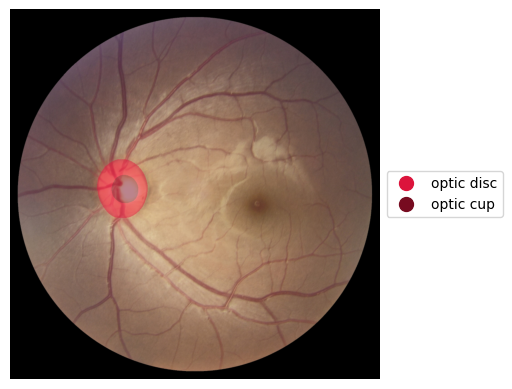

In [8]:
image_path = 'examples/T0011.jpg'
image_type = 'Fundus'

image, pred_mask = inference_recognition(image_path, image_type)

### CT Example

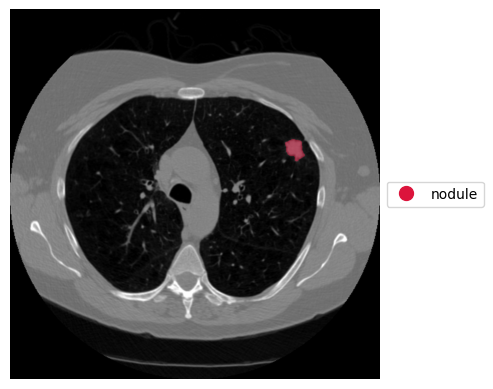

In [9]:
image_path = 'biomedparse_datasets/BiomedParseData-Demo/demo/01_CT_lung.png'
image_type = 'CT-Chest'

image, pred_mask = inference_recognition(image_path, image_type)

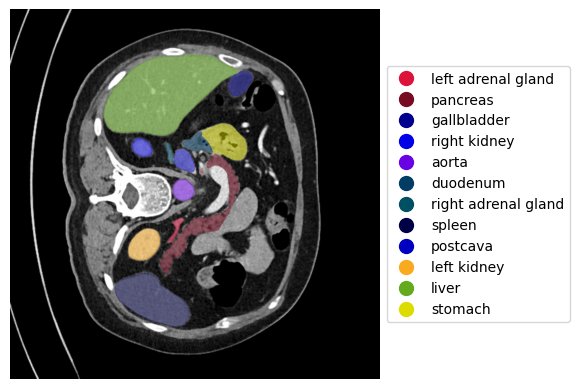

In [10]:
image_path = 'biomedparse_datasets/BiomedParseData-Demo/demo/06_CT_abdomen.png'
image_type = 'CT-Abdomen'

image, pred_mask = inference_recognition(image_path, image_type)

### MRI Example

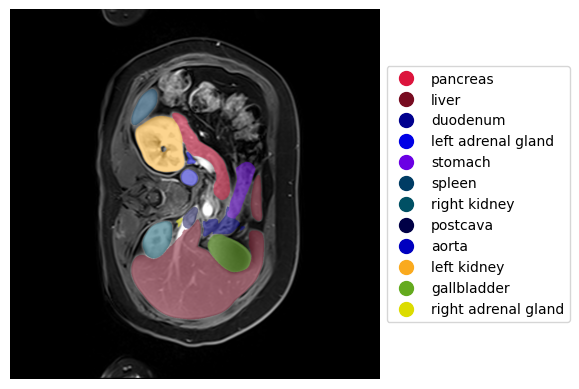

In [11]:
image_path = 'biomedparse_datasets/BiomedParseData-Demo/demo/13_MRI_abdomen.png'
image_type = 'MRI-Abdomen'

image, pred_mask = inference_recognition(image_path, image_type)

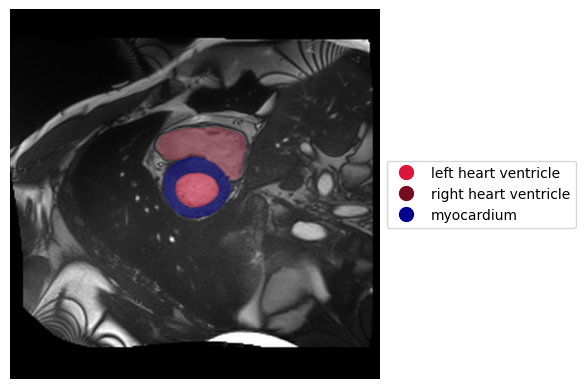

In [12]:
image_path = 'biomedparse_datasets/BiomedParseData-Demo/demo/08_MRI_heart.png'
image_type = 'MRI-Cardiac'

image, pred_mask = inference_recognition(image_path, image_type)